# Part I: The binomial tree: Option Valuation

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import copy
from numpy import random
from scipy.stats import norm

In [3]:
# Define functions
def buildTree(S,sigma,T,N):
    dt = T/N   
    matrix = np.zeros((N+1, N+1))
    
    u = math.exp(sigma*math.sqrt(dt)) 
    d = math.exp(-sigma*math.sqrt(dt)) # Use volatility to approximate
    
    # Iterate over the lower triangle
    for i in np.arange(N+1): # iterate over rows
        for j in np.arange(i+1): # iterate over columns
            # Hint: express each cell as a combination of up and down moves
            matrix[i,j] = S * d**(i-j) * u**j
            
    return matrix

def valueOptionMatrix(tree,T,r,K,sigma,optiontype = 0):
    dt = T/N
    
    u = math.exp(sigma*math.sqrt(dt)) 
    d = math.exp(-sigma*math.sqrt(dt))
    
    p = (math.exp(r*dt)-d)/(u-d)
    
    columns = tree.shape[1]
    rows = tree.shape[0]
    
    # Walk backward, we start in last row of the matrix
    
    # Add the payoff function in the last row
    if optiontype ==0: # European Call option
        for c in np.arange(columns):
            S = tree[rows-1, c] # value in the matrix
            tree[rows-1, c] = max(0,S-K)
    if optiontype ==1: # European Put option
        for c in np.arange(columns):
            S = tree[rows-1, c] # value in the matrix
            tree[rows-1, c] = max(0,K-S)
            
    # For all other rows, we need to combine from previous rows
    # We walk backwards, from the last row to the first row
    for i in np.arange(rows-1)[::-1]:
        for j in np.arange(i+1):
            down = tree[i+1,j]
            up = tree[i+1,j+1]
            tree[i,j] = math.exp(-r*dt) * (p*up + (1-p)*down)

    return tree

def AmericanOption(tree,T,r,K,sigma,optiontype=0):
    stockprice = copy.deepcopy(tree)
    dt = T/N
    
    u = math.exp(sigma*math.sqrt(dt)) 
    d = math.exp(-sigma*math.sqrt(dt))
    
    p = (math.exp(r*dt)-d)/(u-d)
    
    columns = tree.shape[1]
    rows = tree.shape[0]
    
    if optiontype == 0: #American Call option
        for c in np.arange(columns):
            S = tree[rows-1, c] 
            tree[rows-1, c] = max(0,S-K)

        for i in np.arange(rows-1)[::-1]:
            for j in np.arange(i+1):
                down = tree[i+1,j]
                up = tree[i+1,j+1]
                eu_value = math.exp(-r*dt) * (p*up + (1-p)*down)
                tree[i,j] = max(eu_value,stockprice[i,j]-K,0)
                
    if optiontype == 1: #American Put option
        for c in np.arange(columns):
            S = tree[rows-1, c] 
            tree[rows-1, c] = max(0,K-S)

        for i in np.arange(rows-1)[::-1]:
            for j in np.arange(i+1):
                down = tree[i+1,j]
                up = tree[i+1,j+1]
                eu_value = math.exp(-r*dt) * (p*up + (1-p)*down)
                tree[i,j] = max(eu_value,K-stockprice[i,j],0)
        
    return tree

def BlackScholesValue(St, K, r, sigma, tau, optiontype=0):
    """
    Return Black-Scholes Value of an European call option
    optiontype == 0 : Call option
    optiontype == 1 : Put option
    """
    d1 = (math.log(St/K) + (r + (0.5 * sigma**2)) * tau) / (sigma * math.sqrt(tau))
    d2 = d1 - (sigma * math.sqrt(tau))

    if optiontype == 0: #Call option
        Value = St * norm.cdf(d1) - (K*math.exp(-r*tau) * norm.cdf(d2))
    if optiontype == 1: #Put option
        Value = (K*math.exp(-r*tau) * norm.cdf(-1*d2)) - St * norm.cdf(-1*d1)
    return Value

In [4]:
# Build Tree
sigma = 0.1
S = 80
T = 1
N = 2

print(buildTree(S, sigma, T, N))

[[80.          0.          0.        ]
 [74.53851387 85.86165282  0.        ]
 [69.44987563 80.         92.15279281]]


In [5]:
# Build Option Tree
sigma = 0.1
S = 80
T = 1
N = 2

K = 85 
r = 0.1

tree = buildTree(S, sigma, T, N)
print(valueOptionMatrix(tree, T, r, K, sigma,0))

[[4.61654023 0.         0.        ]
 [0.         5.74640373 0.        ]
 [0.         0.         7.15279281]]


In [6]:
# Execution
sigma = 0.2 # volality
S0 = 100 # current price of the stock
T = 1 # maturity
N = 50 # number of simulation steps

K = 99 # strike price
r = 0.06 # one year interest rate

tree = buildTree(S0,sigma,T,N) # Store the stock price
option_value = valueOptionMatrix(tree,T,r,K,sigma)
BS_value = BlackScholesValue(S0, K, r, sigma, T, 0)

print(option_value[0,0])
print(BS_value)

11.546434850755071
11.544280227051097


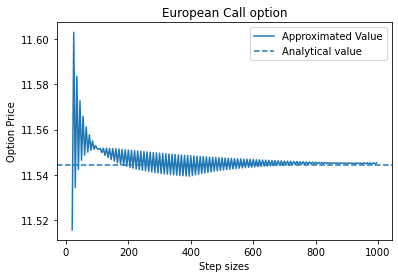

In [7]:
# Play around with different ranges of N and step sizes
N_range = np.arange(20,1000,5)
sigma = 0.2 # volality
S0 = 100 # current price of the stock
T = 1 # maturity
K = 99 # strike price
r = 0.06 # one year interest rate

# Calculate the option price for the correct parameters
optionPriceAnalytical = BlackScholesValue(S0, K, r, sigma, T, 0)

# Calculate option price for each n in N
priceApproximatedly = []
for n in N_range:
    N = n
    treeN = buildTree(S0,sigma,T,N)
    priceApproximatedly.append(valueOptionMatrix(treeN,T,r,K,sigma)[0,0])

# use matplotlib to plot the analytical value and the approximated value for each N
plt.plot(N_range, priceApproximatedly, label = 'Approximated Value')
plt.axhline(y=optionPriceAnalytical,ls="--", label = 'Analytical value')

plt.ylabel('Option Price')
plt.xlabel('Step sizes')
plt.title('European Call option')
plt.legend()
plt.show()

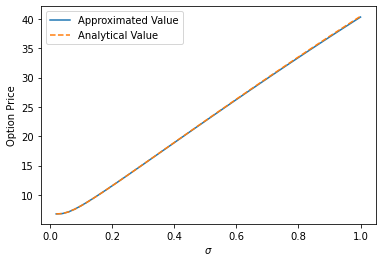

In [8]:
sigma_range = np.linspace(0.02,1,50)
N = 50
price_approx=[]
price_analytical = []
for i in sigma_range:
    sigma = i
    treeN = buildTree(S0,sigma,T,N)
    price_approx.append(valueOptionMatrix(treeN,T,r,K,sigma)[0,0])
    price_analytical.append(BlackScholesValue(S0, K, r, sigma, T, 0))
    
plt.plot(sigma_range, price_approx, label = 'Approximated Value')
plt.plot(sigma_range, price_analytical,'--', label = 'Analytical Value')
plt.ylabel('Option Price')
plt.xlabel(r'$\sigma$')
plt.legend()
plt.show()

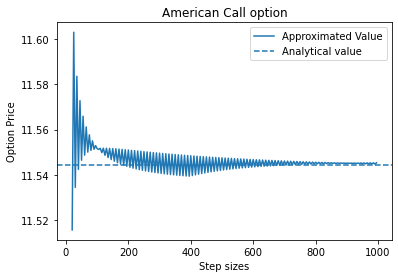

In [9]:
# American Call -- Almost identical to European Call


N_range = np.arange(20,1000,5)
sigma = 0.2 
S0 = 100 
T = 1 
K = 99 
r = 0.06 


optionPriceAnalytical = BlackScholesValue(S0, K, r, sigma, T, 0)


priceApproximatedly = []
for n in N_range:
    N = n
    treeN = buildTree(S0,sigma,T,N)
    priceApproximatedly.append(AmericanOption(treeN,T,r,K,sigma)[0,0])


plt.plot(N_range, priceApproximatedly, label = 'Approximated Value')
plt.axhline(y=optionPriceAnalytical,ls="--", label = 'Analytical value')

plt.ylabel('Option Price')
plt.xlabel('Step sizes')
plt.title('American Call option')
plt.legend()
plt.show()

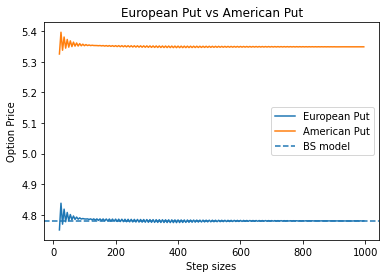

In [10]:
# European Put vs American Put
N_range = np.arange(20,1000,5)
sigma = 0.2 
S0 = 100 
T = 1 
K = 99 
r = 0.06 


optionPriceAnalytical = BlackScholesValue(S0, K, r, sigma, T, 1)

EuropeanPut = []
AmericanPut = []
for n in N_range:
    N = n
    treeN = buildTree(S0,sigma,T,N)
    EuropeanPut.append(valueOptionMatrix(treeN,T,r,K,sigma,1)[0,0])
    treeN = buildTree(S0,sigma,T,N)
    AmericanPut.append(AmericanOption(treeN,T,r,K,sigma,1)[0,0])


plt.plot(N_range, EuropeanPut, label = 'European Put')
plt.plot(N_range, AmericanPut, label = 'American Put')
plt.axhline(y=optionPriceAnalytical,ls="--", label = 'BS model')

plt.ylabel('Option Price')
plt.xlabel('Step sizes')
plt.title('European Put vs American Put')
plt.legend()
plt.show()

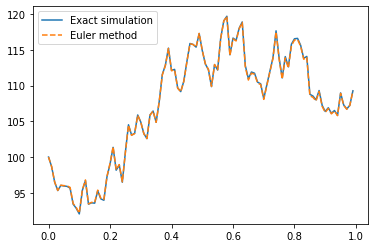

In [11]:
# Ito process: the stock price (underlying asset)
M = 100
T = 1
delta_t = T/M
t = np.arange(0,T, delta_t)
sigma = 0.2 # volatility
r = 0.06 # interest rate
K = 99 # strike price

# To simulate the evolution of stock price, initiate the array to store it
S_exact = np.zeros(M)
S_exact[0] = 100 # stock price today
S_euler = np.zeros(M)
S_euler[0] = 100

Z = np.zeros(M)

for m in range(1,M):
    Z[m] = random.normal(0,1)
    # Exact simulation GBM
    S_exact[m] = S_exact[m-1] * math.exp((r-1/2*sigma**2)*delta_t + sigma*math.sqrt(delta_t)*Z[m])
    # Approximate simulation GBM with Euler method
    S_euler[m] = S_euler[m-1] + r*S_euler[m-1]*delta_t + sigma*S_euler[m-1]*math.sqrt(delta_t)*Z[m]
    

plt.plot(t,S_exact, label = 'Exact simulation')
plt.plot(t,S_euler, '--', label = 'Euler method')
plt.legend()

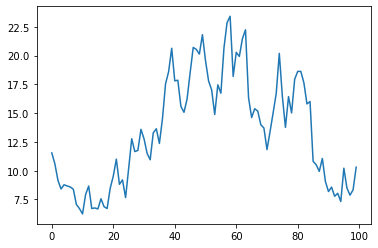

In [12]:
# the Black-Scholes formula for a call option
# S(t) already simulated in the previous part
V = np.zeros(len(t))
K = 99

for i in range(len(t)):
    tau = T - t[i]
    S = np.copy(S_euler)
    V[i] = BlackScholesValue(S[i], K, r, sigma, tau, 0)
    #d1 = (math.log(S[i]/K) + (r+1/2*sigma**2) + tau)/(sigma*math.sqrt(tau))
    #d2 = d1 - sigma*math.sqrt(tau)
    #V[i] = S[i]*norm.cdf(d1) - math.exp(-r*tau)*K*norm.cdf(d2)
plt.plot(V)